In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay

In [3]:
from data.utils import add_experience, feature_classification, astype_category

In [4]:
# DataFrame 초기 세팅
hr_df = pd.read_csv(Path.cwd() / 'data' / 'HR-Employee-Attrition.csv')
hr_df = (hr_df
         .pipe(add_experience)
         .pipe(feature_classification, return_dataframe=True)
         .pipe(astype_category)
         .set_index('EmployeeNumber')
)
hr_df = (hr_df
         .assign(Attrition=lambda df: df['Attrition'].replace({'Yes':1, 'No':0}))
         .assign(OverTime=lambda df: df['OverTime'].replace({'Yes':1, 'No':0}))
)
hr_df.columns

Index(['MonthlyIncome', 'PercentSalaryHike', 'StockOptionLevel', 'Age',
       'Gender', 'MaritalStatus', 'Education', 'EducationField',
       'DistanceFromHome', 'NumCompaniesWorked', 'TotalWorkingYears',
       'Experienced', 'Department', 'BusinessTravel', 'JobLevel', 'JobRole',
       'JobInvolvement', 'OverTime', 'WorkLifeBalance',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'PerformanceRating',
       'RelationshipSatisfaction', 'Attrition'],
      dtype='object')

In [5]:
# 필요 내용 category 변경 확인
hr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1470 entries, 1 to 2068
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   MonthlyIncome             1470 non-null   int64   
 1   PercentSalaryHike         1470 non-null   int64   
 2   StockOptionLevel          1470 non-null   int64   
 3   Age                       1470 non-null   int64   
 4   Gender                    1470 non-null   category
 5   MaritalStatus             1470 non-null   category
 6   Education                 1470 non-null   category
 7   EducationField            1470 non-null   category
 8   DistanceFromHome          1470 non-null   int64   
 9   NumCompaniesWorked        1470 non-null   int64   
 10  TotalWorkingYears         1470 non-null   int64   
 11  Experienced               1470 non-null   category
 12  Department                1470 non-null   category
 13  BusinessTravel            1470 non-null   catego

In [6]:
# categorical variables에 대한 one-hot encoding
hr_df_onehot = pd.get_dummies(hr_df, columns=['BusinessTravel', 'Department', 'Education', 'EducationField', 'EnvironmentSatisfaction',
                                              'Experienced', 'Gender', 'JobRole', 'MaritalStatus'])
hr_df_onehot

,MonthlyIncome,PercentSalaryHike,StockOptionLevel,Age,DistanceFromHome,NumCompaniesWorked,TotalWorkingYears,JobLevel,JobInvolvement,OverTime,...,JobRole_LaboratoryTechnician,JobRole_Manager,JobRole_ManufacturingDirector,JobRole_ResearchDirector,JobRole_ResearchScientist,JobRole_SalesExecutive,JobRole_SalesRepresentative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,
1,5993,11,0,41,1,8,8,2,3,1,...,0,0,0,0,0,1,0,0,0,1
2,5130,23,1,49,8,1,10,2,2,0,...,0,0,0,0,1,0,0,0,1,0
4,2090,15,0,37,2,6,7,1,2,1,...,1,0,0,0,0,0,0,0,0,1
5,2909,11,0,33,3,1,8,1,3,1,...,0,0,0,0,1,0,0,0,1,0
7,3468,12,1,27,2,9,6,1,3,0,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2061,2571,17,1,36,23,4,17,2,4,0,...,1,0,0,0,0,0,0,0,1,0
2062,9991,15,1,39,6,4,9,3,2,0,...,0,0,0,0,0,0,0,0,1,0
2064,6142,20,1,27,4,1,6,2,4,1,...,0,0,1,0,0,0,0,0,1,0


In [7]:
X = hr_df_onehot.drop('Attrition', axis=1)
y = hr_df_onehot['Attrition']
X.shape, y.shape

((1470, 57), (1470,))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1102, 57), (368, 57), (1102,), (368,))

In [9]:
# Attribution에 대한 Baseline 파악을 위한 RandomForest 진행
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_split=5, random_state=0, n_jobs=-1).fit(X_train, y_train)

In [10]:
# Accuracy 및 roc_auc_score 확인 → 약 80% 이상의 정확도 및 0.75 이상의 roc_auc_score를 Baseline으로 형성
rf_clf.score(X_test, y_test), roc_auc_score(y_test, rf_clf.predict_proba(X_test)[:, 1])

(0.8586956521739131, 0.7743604004449389)

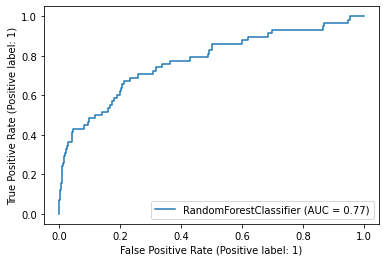

In [11]:
RocCurveDisplay.from_estimator(rf_clf, X_test, y_test)

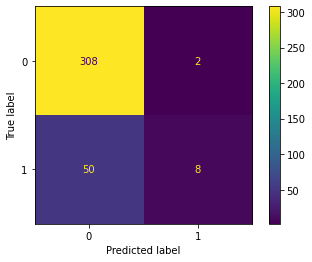

In [12]:
# Baseline에서부터 1로 예측하는 숫자가 높지 않음
ConfusionMatrixDisplay.from_estimator(rf_clf, X_test, y_test)

In [13]:
tree = DecisionTreeClassifier(max_depth=7, min_samples_split=5, random_state=0).fit(X_train, y_train)
tree.score(X_test, y_test)

0.8233695652173914

In [14]:
feature_importances = []
for i in np.random.randint(0, 100, 5):
    tree = DecisionTreeClassifier(max_depth=7, min_samples_split=5, random_state=i).fit(X_train, y_train)
    df_feature_importances = pd.DataFrame(tree.feature_importances_, index=X.columns)
    feature_importances.append(df_feature_importances)
feature_importances

[                                         0
 MonthlyIncome                     0.089701
 PercentSalaryHike                 0.000000
 StockOptionLevel                  0.026429
 Age                               0.078400
 DistanceFromHome                  0.030094
 NumCompaniesWorked                0.000000
 TotalWorkingYears                 0.107154
 JobLevel                          0.087017
 JobInvolvement                    0.024590
 OverTime                          0.080239
 WorkLifeBalance                   0.016770
 TrainingTimesLastYear             0.000000
 YearsAtCompany                    0.001769
 YearsInCurrentRole                0.000000
 YearsSinceLastPromotion           0.061587
 YearsWithCurrManager              0.021064
 JobSatisfaction                   0.016534
 PerformanceRating                 0.000000
 RelationshipSatisfaction          0.054894
 BusinessTravel_Non-Travel         0.014832
 BusinessTravel_Travel_Frequently  0.051240
 BusinessTravel_Travel_Rarely   

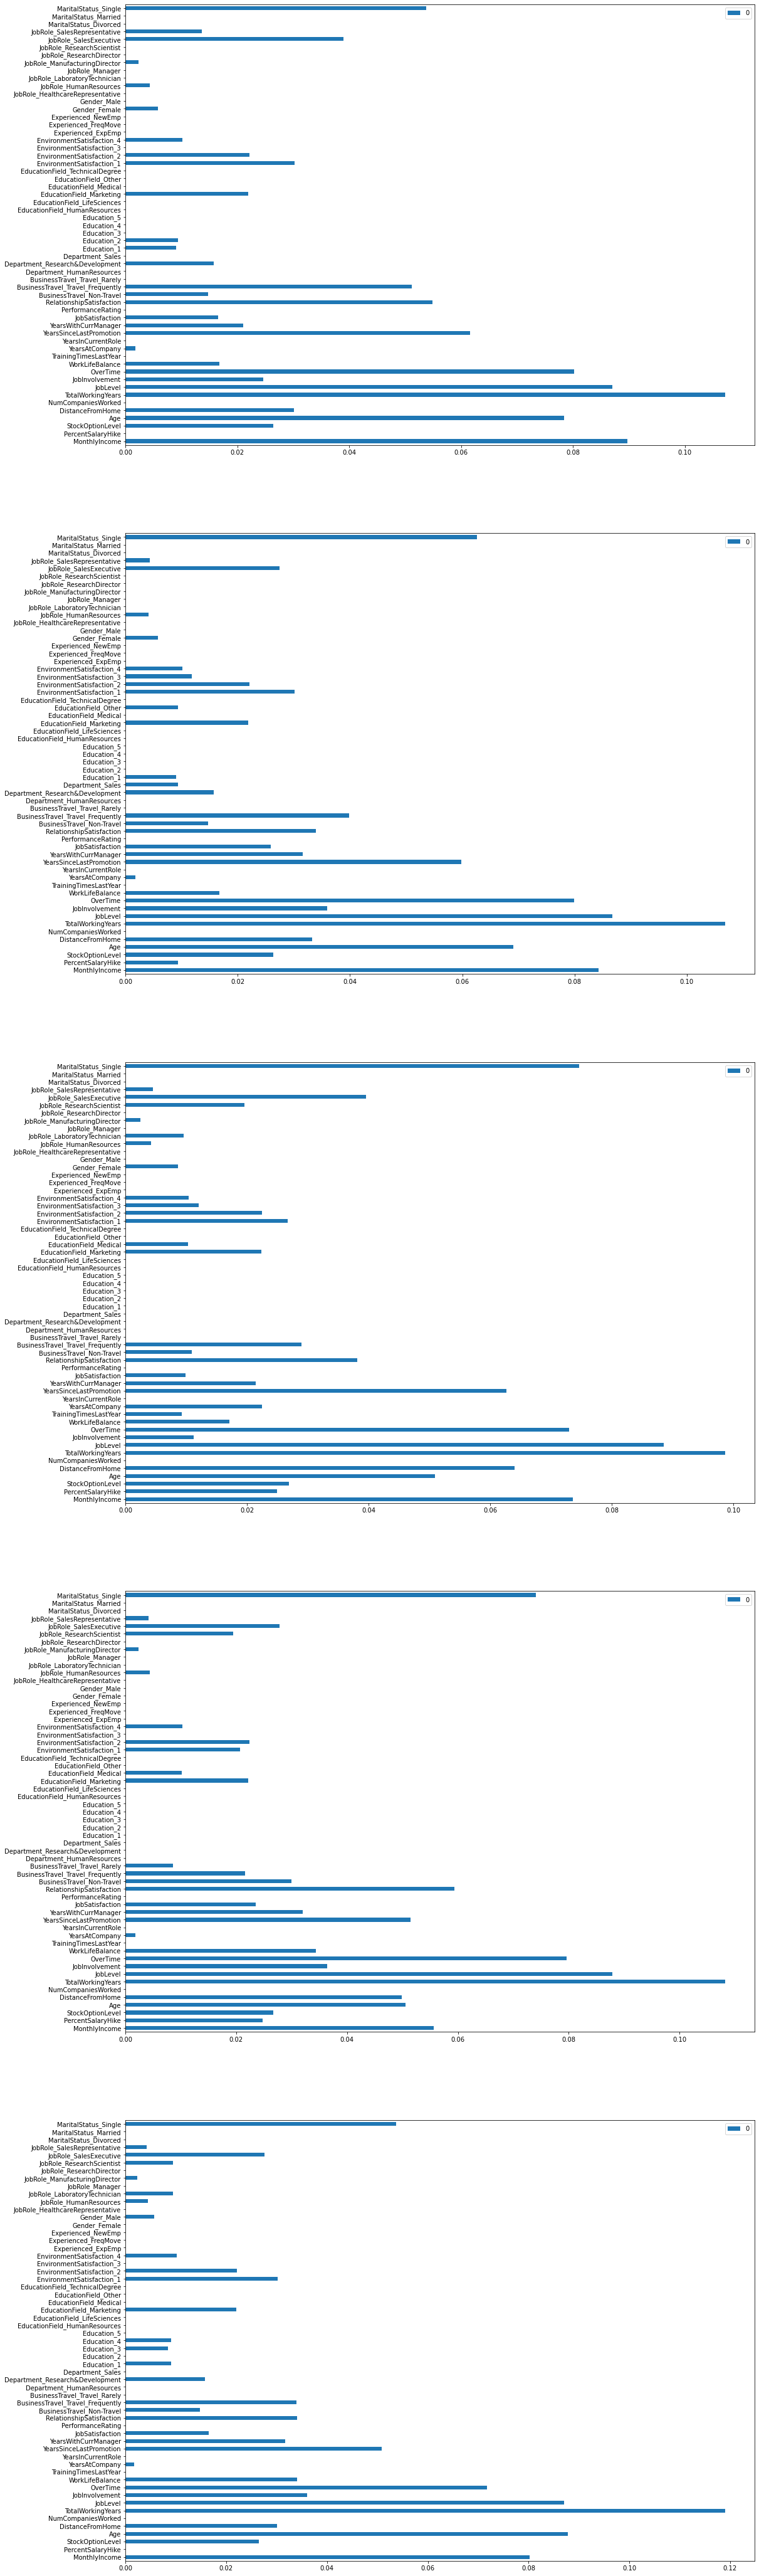

In [15]:
fig, axs = plt.subplots(5, 1, figsize=(18, 75))
for imp, ax in zip(feature_importances, axs.ravel()):
    imp.plot.barh(fontsize=10, ax=ax)